## IoT-Based Energy Consumption Analysis and Forecasting for Building Systems


***

**Project Owner:** Ling-Yun, Huang

**Skills:** 

***

In [1]:
# Data handling & visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data split and scaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Machine learning models
from sklearn.ensemble import RandomForestRegressor

# Gradient boosting frameworks
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data Preprossing

In [2]:
# Import datasets
EC1 = pd.read_csv("KwhConsumptionBlower78_1.csv")
EC2 = pd.read_csv("KwhConsumptionBlower78_2.csv")
EC3 = pd.read_csv("KwhConsumptionBlower78_3.csv")

# Combine Datasets
raw_data = pd.concat([EC1,EC2,EC3], ignore_index=True)
print(raw_data.head())
print(raw_data.info())
df = raw_data.copy()

   Unnamed: 0      TxnDate   TxnTime  Consumption
0       76229  01 Jan 2022  16:55:52        1.010
1       76258  01 Jan 2022  21:45:29        0.908
2       76287  01 Jan 2022  12:24:52        0.926
3       76316  01 Jan 2022  04:07:36        0.928
4       76345  01 Jan 2022  06:52:25        0.916
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606 entries, 0 to 3605
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   3606 non-null   int64  
 1   TxnDate      3606 non-null   object 
 2   TxnTime      3606 non-null   object 
 3   Consumption  3606 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 112.8+ KB
None


In [3]:
# The statistical summary of Energy Consumption
df['Consumption'].describe()

count    3606.000000
mean        2.781508
std         2.961248
min         0.000000
25%         0.948000
50%         1.032000
75%         4.005500
max        27.284000
Name: Consumption, dtype: float64

In [4]:
## Feature Engineering
# Create a datetime column from 'TxnDate' and 'TxnTime'
df['datetime'] = pd.to_datetime(df['TxnDate'] + ' ' + df['TxnTime'], format='%d %b %Y %H:%M:%S')
df = df.sort_values('datetime').reset_index(drop=True) # sort by datetime

# Extract time-based features
df['hour_of_day'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Compute rolling statistics with 1-hour window
df = df.set_index('datetime')
df['rolling_mean_1h'] = df['Consumption'].rolling('1h', closed='left').mean()
df['rolling_std_1h'] = df['Consumption'].rolling('1h', closed='left').std()

# create lag features
df['lag_1'] = df['Consumption'].shift(1)
df['lag_2'] = df['Consumption'].shift(2)
df['lag_3'] = df['Consumption'].shift(3)

# Encode hour of day and day of week as cyclic features
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day']/24)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

df = df.reset_index() # reset the index
df.to_csv("energy_consumption_features.csv", index=False) # save to csv
print(df.head()) # preview the dataset

             datetime  Unnamed: 0      TxnDate   TxnTime  Consumption  \
0 2022-01-01 00:22:28       77476  01 Jan 2022  00:22:28        1.030   
1 2022-01-01 00:42:33       76780  01 Jan 2022  00:42:33        0.904   
2 2022-01-01 01:01:51       76954  01 Jan 2022  01:01:51        0.904   
3 2022-01-01 01:41:48       76548  01 Jan 2022  01:41:48        1.850   
4 2022-01-01 02:22:52       77070  01 Jan 2022  02:22:52        1.878   

   hour_of_day  day_of_week  is_weekend  rolling_mean_1h  rolling_std_1h  \
0            0            5           1              NaN             NaN   
1            0            5           1            1.030             NaN   
2            1            5           1            0.967        0.089095   
3            1            5           1            0.904        0.000000   
4            2            5           1            1.850             NaN   

   lag_1  lag_2  lag_3  hour_sin  hour_cos   dow_sin   dow_cos  
0    NaN    NaN    NaN  0.000000  1.000

### Exploratory Data Analysis (EDA)

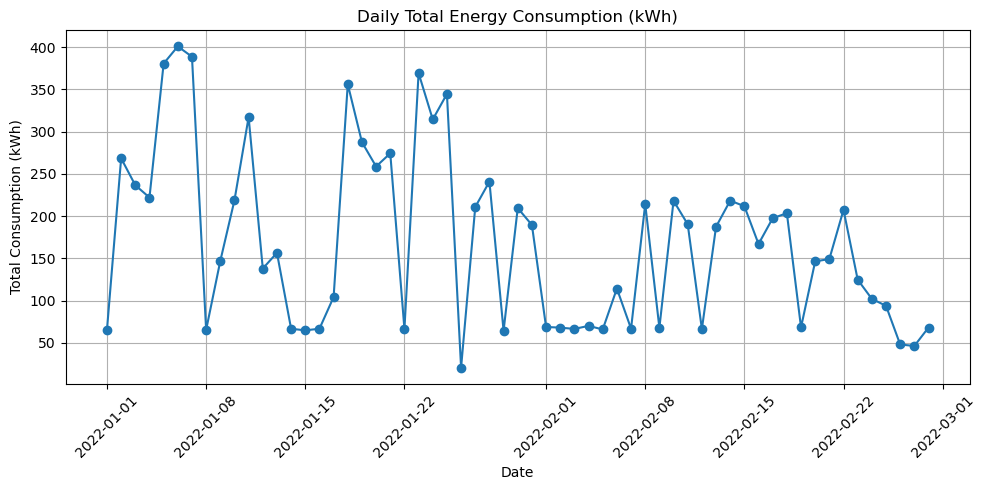

In [5]:
# Load the processed dataset
df = pd.read_csv("energy_consumption_features.csv", parse_dates=['datetime'])

# Figure: Daily total energy consumption trend
daily_consumption = df.groupby(df['datetime'].dt.date)['Consumption'].sum()
plt.figure(figsize=(10,5))
plt.plot(daily_consumption.index, daily_consumption.values, marker='o')
plt.title("Daily Total Energy Consumption (kWh)")
plt.xlabel("Date")
plt.ylabel("Total Consumption (kWh)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

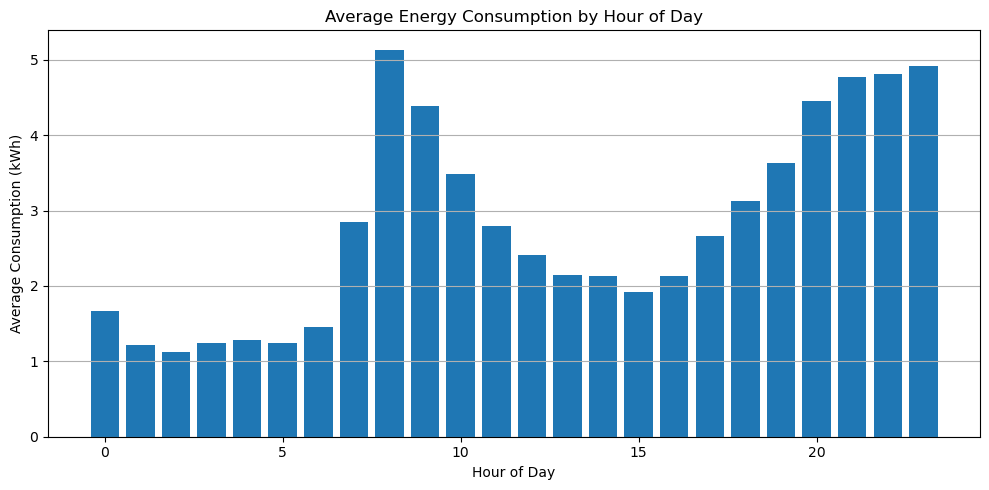

In [6]:
# Figure: Average energy consumption by hour of day
hourly_avg = df.groupby('hour_of_day')['Consumption'].mean()
plt.figure(figsize=(10,5))
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title("Average Energy Consumption by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Consumption (kWh)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

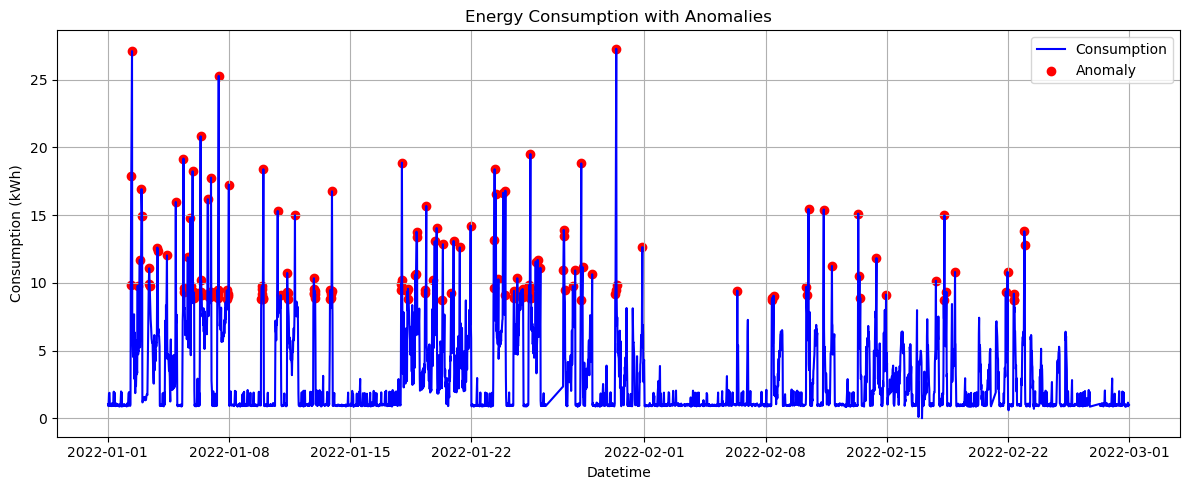

In [7]:
# Figure: Anomaly detection using 95th percentile as threshold
threshold = df['Consumption'].quantile(0.95)
df['is_anomaly'] = df['Consumption'] > threshold

plt.figure(figsize=(12,5))
plt.plot(df['datetime'], df['Consumption'], label='Consumption', color='blue')
plt.scatter(df.loc[df['is_anomaly'], 'datetime'],
            df.loc[df['is_anomaly'], 'Consumption'],
            color='red', label='Anomaly')
plt.title("Energy Consumption with Anomalies")
plt.xlabel("Datetime")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Modelling

In [8]:
# Define X, y
X = df[['rolling_mean_1h', 'rolling_std_1h', 'lag_1', 'lag_2', 'lag_3',
        'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend']]
y = df['Consumption']

In [9]:
# Define SMAPE socre
def smape_score(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10)
    ) * 100


In [10]:
models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=32, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=1000, learning_rate=0.005, random_state=32, n_jobs=-1, 
                              min_child_samples=20, min_split_gain=0.0, max_depth=12, verbose=-1),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.005, random_state=32, n_jobs=-1, tree_method="hist")
}

tscv = TimeSeriesSplit(n_splits=5)

results = {name: [] for name in models.keys()}

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # deal NaN
    mask_train = ~X_train.isna().any(axis=1)
    X_train, y_train = X_train[mask_train], y_train[mask_train]
    mask_test = ~X_test.isna().any(axis=1)
    X_test, y_test = X_test[mask_test], y_test[mask_test]

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        smape_val = smape_score(y_test, y_pred)

        results[name].append((rmse, mae, r2, smape_val))
        print(f"{name} | Fold {fold+1}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}, SMAPE={smape_val:.2f}%")

# Average results
print("\nAverage performance across folds:")
for name in models.keys():
    avg_rmse = np.mean([r[0] for r in results[name]])
    avg_mae  = np.mean([r[1] for r in results[name]])
    avg_r2   = np.mean([r[2] for r in results[name]])
    avg_smape = np.mean([r[3] for r in results[name]])
    print(f"{name}: RMSE={avg_rmse:.3f}, MAE={avg_mae:.3f}, R²={avg_r2:.3f}, SMAPE={avg_smape:.2f}%")

RandomForest | Fold 1: RMSE=1.185, MAE=0.717, R²=0.817, SMAPE=29.15%
LightGBM | Fold 1: RMSE=1.064, MAE=0.622, R²=0.852, SMAPE=26.76%
XGBoost | Fold 1: RMSE=1.150, MAE=0.757, R²=0.827, SMAPE=33.32%
RandomForest | Fold 2: RMSE=1.045, MAE=0.597, R²=0.861, SMAPE=17.77%
LightGBM | Fold 2: RMSE=1.075, MAE=0.637, R²=0.853, SMAPE=21.05%
XGBoost | Fold 2: RMSE=1.058, MAE=0.649, R²=0.857, SMAPE=22.46%
RandomForest | Fold 3: RMSE=0.750, MAE=0.398, R²=0.748, SMAPE=21.39%
LightGBM | Fold 3: RMSE=0.710, MAE=0.385, R²=0.775, SMAPE=21.46%
XGBoost | Fold 3: RMSE=0.752, MAE=0.473, R²=0.747, SMAPE=28.73%
RandomForest | Fold 4: RMSE=0.947, MAE=0.535, R²=0.779, SMAPE=21.98%
LightGBM | Fold 4: RMSE=0.930, MAE=0.537, R²=0.787, SMAPE=21.97%
XGBoost | Fold 4: RMSE=0.934, MAE=0.555, R²=0.785, SMAPE=24.71%
RandomForest | Fold 5: RMSE=0.636, MAE=0.360, R²=0.852, SMAPE=18.69%
LightGBM | Fold 5: RMSE=0.571, MAE=0.308, R²=0.881, SMAPE=15.63%
XGBoost | Fold 5: RMSE=0.600, MAE=0.388, R²=0.869, SMAPE=22.65%

Average p

In [11]:
# LSTM data prepared
features = ['Consumption', 'rolling_mean_1h', 'rolling_std_1h', 'lag_1', 'lag_2', 'lag_3',
            'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend']

mask = ~df[features].isna().any(axis=1) & ~df['Consumption'].isna()
data = df[features][mask].values
target = df['Consumption'][mask].values

# Standard scaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

timesteps = 50

X, y = [], []
for i in range(timesteps, len(data_scaled)):
    X.append(data_scaled[i-timesteps:i])
    y.append(target[i])

X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(2982, 50, 11) (2982,)


In [12]:
# Define LSTM model
model = Sequential()
model.add(Input(shape=(X.shape[1], X.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))


model.compile(optimizer=Adam(learning_rate=0.0025), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
history = model.fit(
    X, y,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    shuffle=False
)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.6829 - mae: 1.7014 - val_loss: 1.7539 - val_mae: 0.8316
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8655 - mae: 1.0629 - val_loss: 1.1381 - val_mae: 0.6498
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2020 - mae: 0.9091 - val_loss: 0.9412 - val_mae: 0.6216
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9973 - mae: 0.8510 - val_loss: 0.8072 - val_mae: 0.5389
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8587 - mae: 0.8043 - val_loss: 0.7286 - val_mae: 0.5204
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6961 - mae: 0.7613 - val_loss: 0.6675 - val_mae: 0.4775
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5975 - mae: 0.7304 - val_loss: 0.6301 - val_mae: 0.4542
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6429 - mae: 0.7400 - val_loss: 0.6264 - val_mae: 0.4834
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.577

In [13]:
# LSTM predict and show result
y_pred = model.predict(X)

rmse_lstm = np.sqrt(mean_squared_error(y, y_pred))
mae_lstm = mean_absolute_error(y, y_pred)
r2_lstm = r2_score(y, y_pred)
smape_lstm = smape_score(y, y_pred)

print(f"LSTM result: RMSE={rmse_lstm:.3f}, MAE={mae_lstm:.3f}, R²={r2_lstm:.3f}, SMAPE={smape_lstm:.2f}%")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM result: RMSE=1.030, MAE=0.540, R²=0.828, SMAPE=71.18%


In [14]:
# Print the summary results all 4 methods
summary = []
for name in results.keys():
    avg_rmse = np.mean([r[0] for r in results[name]])
    avg_mae  = np.mean([r[1] for r in results[name]])
    avg_r2   = np.mean([r[2] for r in results[name]])
    avg_smape = np.mean([r[3] for r in results[name]])
    summary.append([name, avg_rmse, avg_mae, avg_r2, avg_smape])

summary.append(["LSTM", rmse_lstm, mae_lstm, r2_lstm, smape_lstm])

df_results = pd.DataFrame(summary, columns=["Model", "RMSE", "MAE", "R²", "SMAPE (%)"])
df_results

,Model,RMSE,MAE,R²,SMAPE (%)
0,RandomForest,0.912416,0.521408,0.811542,21.798056
1,LightGBM,0.869596,0.497750,0.829625,21.372087
2,XGBoost,0.898574,0.564431,0.817175,26.374506
3,LSTM,1.030197,0.540443,0.827875,71.177575


### Forecasting with best model

In [15]:
# Retrain the model with all historical data
features = ['lag_1','lag_2','lag_3','rolling_mean_1h','rolling_std_1h',
            'hour_sin','hour_cos','dow_sin','dow_cos']
X = df[features]
y = df['Consumption']

# LightGBM
model = LGBMRegressor(n_estimators=1000, learning_rate=0.005, random_state=32)
model.fit(X, y)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.005
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [16]:
# Forecast future 168 hours
n_forecast = 168
last_row = df.iloc[-1].copy()
future_preds = []

for i in range(1, n_forecast+1):
    # new datatime points
    future_time = last_row['datetime'] + pd.Timedelta(hours=1)
    
    # features
    hour_of_day = future_time.hour
    day_of_week = future_time.dayofweek
    hour_sin = np.sin(2 * np.pi * hour_of_day / 24)
    hour_cos = np.cos(2 * np.pi * hour_of_day / 24)
    dow_sin = np.sin(2 * np.pi * day_of_week / 7)
    dow_cos = np.cos(2 * np.pi * day_of_week / 7)
    
    # Lags
    lag_1 = last_row['Consumption']
    lag_2 = last_row['lag_1']
    lag_3 = last_row['lag_2']
    
    # rolling
    rolling_mean_1h = np.mean([lag_1, lag_2, lag_3])
    rolling_std_1h = np.std([lag_1, lag_2, lag_3])
    
    # build feature vector
    X_pred = pd.DataFrame([[lag_1, lag_2, lag_3, rolling_mean_1h, rolling_std_1h,
                            hour_sin, hour_cos, dow_sin, dow_cos]],
                          columns=features)
    
    # predict next hour
    y_pred = model.predict(X_pred)[0]
    future_preds.append(y_pred)
    
    # renew last_row
    last_row['datetime'] = future_time
    last_row['Consumption'] = y_pred
    last_row['lag_1'] = lag_1
    last_row['lag_2'] = lag_2


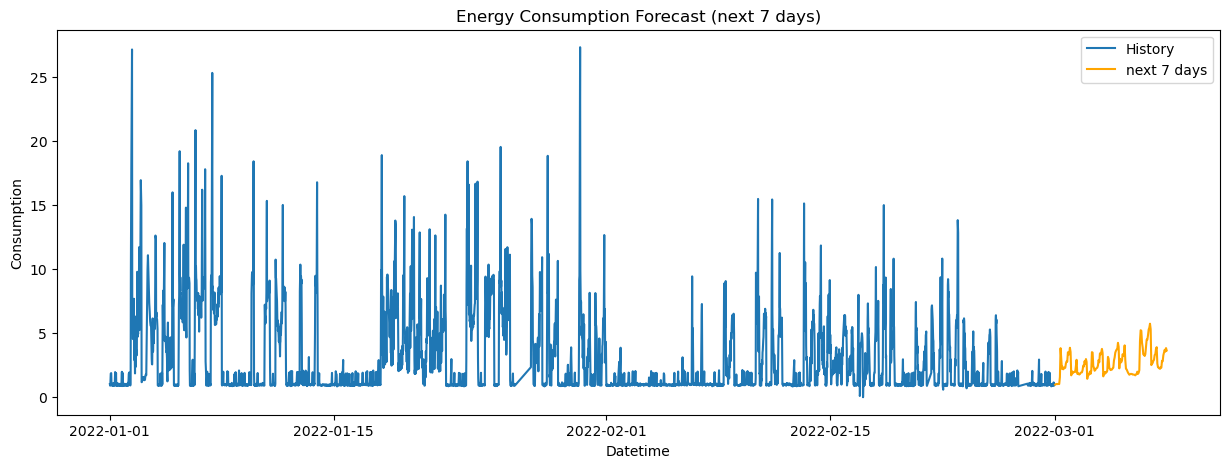

In [17]:
# Plotting the forecasting data
future_dates = [df['datetime'].iloc[-1] + pd.Timedelta(hours=i) for i in range(1, n_forecast+1)]

plt.figure(figsize=(15,5))
plt.plot(df['datetime'], df['Consumption'], label='History')
plt.plot(future_dates, future_preds, label='next 7 days', color='orange')
plt.xlabel('Datetime')
plt.ylabel('Consumption')
plt.title('Energy Consumption Forecast (next 7 days)')
plt.legend()
plt.show()

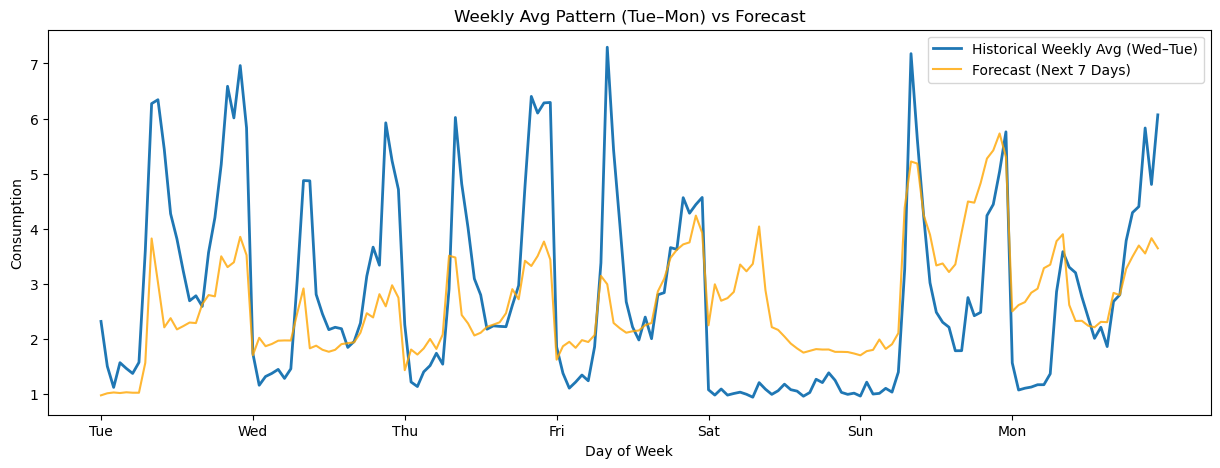

In [18]:
# shift weekday index so Tue=0 ... Sun=6
df['day_of_week'] = (df['datetime'].dt.day_of_week-1) % 7
df['hour'] = df['datetime'].dt.hour

# Everyhour mean in every week energy consumption
weekly_pattern = df.groupby(['day_of_week','hour'])['Consumption'].mean().reset_index()
weekly_pattern['week_hour'] = weekly_pattern['day_of_week']*24 + weekly_pattern['hour']
weekly_pattern = weekly_pattern.sort_values('week_hour')

# Future 7 days energy consumption
future_df = pd.DataFrame({"datetime": future_dates, "Consumption": future_preds})
future_df['day_of_week'] = (future_df['datetime'].dt.day_of_week - 1) % 7
future_df['hour'] = future_df['datetime'].dt.hour
future_df['week_hour'] = future_df['day_of_week']*24 + future_df['hour']

# Plot
plt.figure(figsize=(15,5))
plt.plot(weekly_pattern['week_hour'], weekly_pattern['Consumption'], 
         label='Historical Weekly Avg (Wed–Tue)', linewidth=2)
plt.plot(future_df['week_hour'], future_df['Consumption'], 
         label='Forecast (Next 7 Days)', color='orange', alpha=0.8)

plt.xticks(ticks=range(0,168,24), labels=['Tue','Wed','Thu','Fri','Sat','Sun','Mon'])
plt.xlabel('Day of Week')
plt.ylabel('Consumption')
plt.title('Weekly Avg Pattern (Tue–Mon) vs Forecast')
plt.legend()
plt.show()

#### Create an hourly dataset to train LSTM

In [19]:
# hourly dataset
hourly = (
    df.set_index('datetime')
      .resample('1h')
      .agg(Consumption=('Consumption','mean'), obs_per_hour=('Consumption','size'))
)
hourly

,Consumption,obs_per_hour
datetime,,
2022-01-01 00:00:00,0.967000,2
2022-01-01 01:00:00,1.377000,2
2022-01-01 02:00:00,1.485000,2
2022-01-01 03:00:00,0.929333,3
2022-01-01 04:00:00,0.922667,3
...,...,...
2022-02-28 19:00:00,0.968000,3
2022-02-28 20:00:00,0.932000,3
2022-02-28 21:00:00,0.960000,2


In [20]:
# deal with missing data
hourly['Consumption'] = hourly['Consumption'].interpolate(limit_direction='both')
hourly['obs_per_hour'] = hourly['obs_per_hour'].fillna(0)

# time features
hourly['hour_of_day'] = hourly.index.hour
hourly['day_of_week'] = hourly.index.dayofweek
hourly['is_weekend']  = (hourly['day_of_week'] >= 5).astype(int)

# create lag features
hourly['lag_1'] = hourly['Consumption'].shift(1)
hourly['lag_2'] = hourly['Consumption'].shift(2)
hourly['lag_3'] = hourly['Consumption'].shift(3)
#hourly['lag_24'] = hourly['Consumption'].shift(24)

# Encode hour of day and day of week as cyclic features
hourly['hour_sin'] = np.sin(2 * np.pi * hourly['hour_of_day']/24)
hourly['hour_cos'] = np.cos(2 * np.pi * hourly['hour_of_day']/24)
hourly['dow_sin'] = np.sin(2 * np.pi * hourly['day_of_week']/7)
hourly['dow_cos'] = np.cos(2 * np.pi * hourly['day_of_week']/7)

# drop NaN
hourly = hourly.dropna()

# split the dataset
split_idx = int(len(hourly)*0.8)
train_df = hourly.iloc[:split_idx]
val_df   = hourly.iloc[split_idx:]

# standard scaler
features = ['Consumption', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', #'lag_24',
            'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df[features])
X_val_scaled   = scaler.transform(val_df[features])

y_train = train_df['Consumption'].values
y_val   = val_df['Consumption'].values

In [21]:
# Make LSTM sequence, using 168 hours
def make_sequences(X2d, y1d, lookback=168):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X2d)):
        X_seq.append(X2d[i-lookback:i, :])
        y_seq.append(y1d[i])
    return np.array(X_seq), np.array(y_seq)

lookback = 168
Xtr, ytr = make_sequences(X_train_scaled, y_train, lookback)
Xva, yva = make_sequences(X_val_scaled,   y_val,   lookback)

# Build LSTM model
model = Sequential([
    Input(shape=(Xtr.shape[1], Xtr.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    Xtr, ytr,
    epochs=100,
    batch_size=32,
    validation_data=(Xva, yva),
    callbacks=[es],
    shuffle=False
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 10.9342 - mae: 2.2019 - val_loss: 0.7536 - val_mae: 0.5591
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.7280 - mae: 1.7459 - val_loss: 0.7668 - val_mae: 0.4556
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.6473 - mae: 1.4983 - val_loss: 0.7882 - val_mae: 0.6406
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7025 - mae: 1.3380 - val_loss: 0.6385 - val_mae: 0.4769
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.0901 - mae: 1.2321 - val_loss: 0.5675 - val_mae: 0.4782
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.8292 - mae: 1.1911 - val_loss: 0.5503 - val_mae: 0.4943
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.4437 - mae: 1.0961 - val_loss: 0.5050 - val_mae: 0.4921
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.4214 - mae: 1.1022 - val_loss: 0.5989 - val_mae: 0.5655
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - l

In [22]:
# Predict on validation set
y_pred = model.predict(Xva).flatten()

# Compare with true values
print("y_val shape:", y_val.shape, "y_pred shape:", y_pred.shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
y_val shape: (283,) y_pred shape: (115,)


In [23]:
rmse = np.sqrt(mean_squared_error(y_val[lookback:], y_pred))
mae = mean_absolute_error(y_val[lookback:], y_pred)
r2 = r2_score(y_val[lookback:], y_pred)
smape = smape_score(y_val[lookback:], y_pred)

print(f"LSTM on validation: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}, SMAPE={smape: .2f}%")

LSTM on validation: RMSE=0.678, MAE=0.469, R²=0.390, SMAPE= 32.67%
